In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
warnings.filterwarnings('ignore')

In [ ]:
KEY = "98464488-2db9-4ddc-9b98-6b48f8b623dc" # do not change
LIMIT = 365
COIN = 'BTC'

In [ ]:
def prices(product_id, period=30, granularity=86400, start=None, end=None):
    """
    Fetch historical candlestick data for a cryptocurrency pair from now to the specified number of days in the past.

    :param product_id: The product ID for the crypto pair (e.g., 'BTC-USD').
    :param period: Number of days of historical data to fetch.
    :param granularity: Desired time slice in seconds (60, 300, 900, 3600, 21600, 86400).
    :return: DataFrame containing historical data.
    """
    if not product_id.endswith('-USD'):
        product_id += '-USD'
    product_id = product_id.upper()
    url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"
    if start is None and end is None: # get data from specified number of days ago if date bounds are not specified.
        end = datetime.now()
        start = end - timedelta(days=period)
    coin = product_id.split('-')[0]
    all_data = []

    while start < end:
        end_slice = min(start + timedelta(seconds=granularity * 300), end)
        params = {
            'start': start.isoformat(),
            'end': end_slice.isoformat(),
            'granularity': granularity
        }

        try:
            response = requests.get(url, params=params)
        except ConnectionError:
            print("No internet connection")
            return None, coin
        except ReadTimeoutError:
            print('Your wifi likely doesn\'t allow to access Coinbase API')
            return None, coin

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print("Failed to fetch data:", response.text)
            break

        start = end_slice

    if all_data:
        columns = ['time', 'low', 'high', 'open', 'close', 'volume']
        data = pd.DataFrame(all_data, columns=columns)
        data['time'] = pd.to_datetime(data['time'], unit='s')
        data['change'] = data['close'] - data['open']
        data['pct_change'] = (data['change'] / data['open']) * 100
        return data, coin
    return None, coin

In [ ]:
df, coin = prices(COIN, period=365)

In [ ]:
df

,time,low,high,open,close,volume,change,pct_change
0,2024-12-21,96368.00,99596.57,97762.75,97230.08,6451.432714,-532.67,-0.544860
1,2024-12-20,92115.66,98132.47,97372.20,97765.00,21766.623861,392.80,0.403401
2,2024-12-19,95539.67,102796.22,100148.60,97372.21,23522.128639,-2776.39,-2.772270
3,2024-12-18,99939.82,106528.13,106145.83,100150.73,22294.428355,-5995.10,-5.647984
4,2024-12-17,105337.97,108388.88,106099.98,106136.99,11994.588640,37.01,0.034882
...,...,...,...,...,...,...,...,...
360,2024-12-26,95083.93,99887.00,99358.67,95669.49,11403.372689,-3689.18,-3.712993
361,2024-12-25,97557.48,99484.92,98594.47,99346.28,5254.237060,751.81,0.762528
362,2024-12-24,93426.25,99444.00,94767.88,98594.47,13355.363143,3826.59,4.037855
363,2024-12-23,92360.91,96430.08,95091.15,94764.56,13476.989476,-326.59,-0.343449


## Find the FGI change and close price change correlation

Do this for all the coins

In [ ]:
def get_fgi_data():
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
      fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')
      return fgi_df
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

In [ ]:
def fgi_close_association(coin='BTC'):
  try:
    coinPrices, i = prices(coin, period=LIMIT)
  except:
    print('Invalid coin: ', coin)
    print('Period: ', LIMIT)
    return None
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

  # convert timestamp to date
  fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')

  # inner join the prices on the timestamp
  everything = pd.merge(coinPrices, fgi_df, left_on='time', right_on='timestamp', how='inner')
  everything = pd.get_dummies(everything)

  # create pct_change for the fgi value
  everything['fgi_pct_change'] = everything['value'].pct_change()
  everything['fgi_pct_change'].fillna(0, inplace=True)
  everything['pct_change'].fillna(0, inplace=True)
  correlation = everything.corr()
  item1 = correlation['pct_change']['fgi_pct_change']
  item2 = np.sqrt(mean_squared_error(everything['pct_change'], everything['fgi_pct_change']))
  return {
      'coin': coin,
      'correlation': item1,
      'RMSE': item2
  }

In [ ]:
get_fgi_data()

,timestamp,value,value_classification
0,2025-02-23,40,Neutral
1,2025-02-22,38,Fear
2,2025-02-21,43,Neutral
3,2025-02-20,40,Neutral
4,2025-02-19,37,Fear
...,...,...,...
360,2024-02-29,86,Extreme greed
361,2024-02-28,80,Extreme greed
362,2024-02-27,76,Greed
363,2024-02-26,72,Greed


In [ ]:
coins = ['BTC', 'NEAR', 'ETH', 'AVAX', 'SOL', 'ICP', 'FET']
correlations = [fgi_close_association(coin) for coin in coins]
everything = pd.DataFrame(correlations).sort_values(by='RMSE', ascending=True)

In [ ]:
import altair as alt

# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('RMSE')

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='RMSE'
).properties(
    title='RMSE by Coin'  # Add a title to the chart
)

alt.Chart(...)

In [ ]:
# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('correlation')
everything_sorted['abs_correlation'] = np.abs(everything_sorted['correlation'])

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='abs_correlation'
).properties(
    title='Correlation Magnitude by Coin'  # Add a title to the chart
)

alt.Chart(...)

## Crypto market collector

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Constants

# -------------------------------
# 1. Market-Faceted Metrics
# -------------------------------

def get_global_market_data():
    """
    Fetch overall market data such as total market capitalization, trading volume, and Bitcoin dominance.
    Purpose: Helps understand the overall health and activity of the cryptocurrency market.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return {
            'total_market_cap': data['data']['quote']['USD']['total_market_cap'],
            'total_volume_24h': data['data']['quote']['USD']['total_volume_24h'],
            'btc_dominance': data['data']['btc_dominance'],
            'active_cryptocurrencies': data['data']['active_cryptocurrencies']
        }
    else:
        print(f"Failed to fetch global market data: {response.status_code}")
        return None

def get_tokenomics(coin):
    """
    Fetch tokenomics data such as circulating supply and total supply.
    Purpose: Helps understand the supply dynamics of a coin, which can influence its price.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    params = {
        'symbol': coin
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        supply_data = data['data'][coin]
        return supply_data
    else:
        print(f"Failed to fetch tokenomics for {coin}: {response.status_code}")
        return None

# -------------------------------
# Additional Metrics
# -------------------------------


# Example Usage
if __name__ == "__main__":
    # Fetch global market data
    market_data = get_global_market_data()
    print("Market Data:", market_data)

    # Fetch tokenomics data
    tokenomics_data = get_tokenomics('BTC')
    print("Tokenomics:", tokenomics_data)


Market Data: {'total_market_cap': 3196043160673.366, 'total_volume_24h': 69029258179.4, 'btc_dominance': 59.792514425212, 'active_cryptocurrencies': 10889}
Tokenomics: {'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'category': 'coin', 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,828,256. The last known price of Bitcoin is 96,458.86829604 USD and is down -0.09 over the last 24 hours. It is currently trading on 11958 active market(s) with $16,507,333,253.32 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'slug': 'bitcoin', 'logo': 'https://s2.coinmarketcap.com/static/img/coins/64x64/1.png', 'subreddit': 'bitcoin', 'notice': '', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchain

In [ ]:
pd.json_normalize(tokenomics_data)

,id,name,symbol,category,description,slug,logo,subreddit,notice,tags,...,urls.website,urls.twitter,urls.message_board,urls.chat,urls.facebook,urls.explorer,urls.reddit,urls.technical_doc,urls.source_code,urls.announcement
0,1,Bitcoin,BTC,coin,Bitcoin (BTC) is a cryptocurrency launched in ...,bitcoin,https://s2.coinmarketcap.com/static/img/coins/...,bitcoin,,"[mineable, pow, sha-256, store-of-value, state...",...,[https://bitcoin.org/],[],[https://bitcointalk.org],[],[],"[https://blockchain.info/, https://live.blockc...",[https://reddit.com/r/bitcoin],[https://bitcoin.org/bitcoin.pdf],[https://github.com/bitcoin/bitcoin],[]


In [ ]:
pd.json_normalize(market_data)

,total_market_cap,total_volume_24h,btc_dominance,active_cryptocurrencies
0,3.196043e+12,6.902926e+10,59.792514,10889


# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [ ]:
import pandas as pd
import numpy as np

# Assume you have already fetched data using your prices() function,
# and that your DataFrame (df) has at least the following columns:
# ['time', 'low', 'high', 'open', 'close', 'volume']

# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    # Separate positive and negative gains
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Simple moving average over 'window' periods for gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Alternatively, one can use exponential weighting:
    # avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    # avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram: the difference between MACD and its signal line
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# ----------------------------
# 4. Bollinger Bands
# ----------------------------
# Bollinger Bands are typically computed using a moving average and standard deviation.
# Here we use the 20-period SMA (which we already computed) and a factor of 2 standard deviations.
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

# Optionally, you can drop the intermediate 'BB_STD' column later if not needed:
# df.drop(columns=['BB_STD'], inplace=True)

# ----------------------------
# 5. Volume Indicators
# ----------------------------
# Example 1: 20-period moving average of volume (helps smooth out spikes)
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Example 2: On-Balance Volume (OBV)
# OBV is designed to relate volume flow to price change.
# We'll start OBV at zero and add/subtract volume depending on price movement.
df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

# Clean up temporary columns
df.drop(columns=['daily_return', 'direction'], inplace=True)

# ----------------------------
# View the final DataFrame with the newly computed technical indicators
# ----------------------------
df.tail()

# If you wish to inspect or plot these indicators (for example, overlaying Bollinger Bands on price),
# you can use matplotlib, seaborn, or a plotting library of your choice.

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
360,2024-12-26,95083.93,99887.00,99358.67,95669.49,11403.372689,-3689.18,-3.712993,95605.5820,98652.1874,...,96418.015319,-1016.270190,-808.734079,-207.536111,95605.5820,2356.183308,100317.948617,90893.215383,9275.911450,-265626.613369
361,2024-12-25,97557.48,99484.92,98594.47,99346.28,5254.237060,751.81,0.762528,95746.1480,98706.6072,...,96634.923814,-626.327166,-772.252696,145.925530,95746.1480,2494.354657,100734.857313,90757.438687,8978.086737,-260372.376309
362,2024-12-24,93426.25,99444.00,94767.88,98594.47,13355.363143,3826.59,4.037855,95950.5490,98721.2460,...,96780.075384,-373.652066,-692.532570,318.880504,95950.5490,2554.199737,101058.948474,90842.149526,8991.111714,-273727.739452
363,2024-12-23,92360.91,96430.08,95091.15,94764.56,13476.989476,-326.59,-0.343449,95963.2960,98701.0556,...,96630.777948,-476.948987,-649.415853,172.466867,95963.2960,2547.256867,101057.809735,90868.782265,9563.670381,-287204.728928
364,2024-12-22,94182.98,97387.98,97230.09,95087.75,4933.501277,-2142.34,-2.203371,95989.4325,98653.9224,...,96516.479581,-526.662768,-624.865236,98.202468,95989.4325,2534.805880,101059.044260,90919.820740,9678.410467,-282271.227650


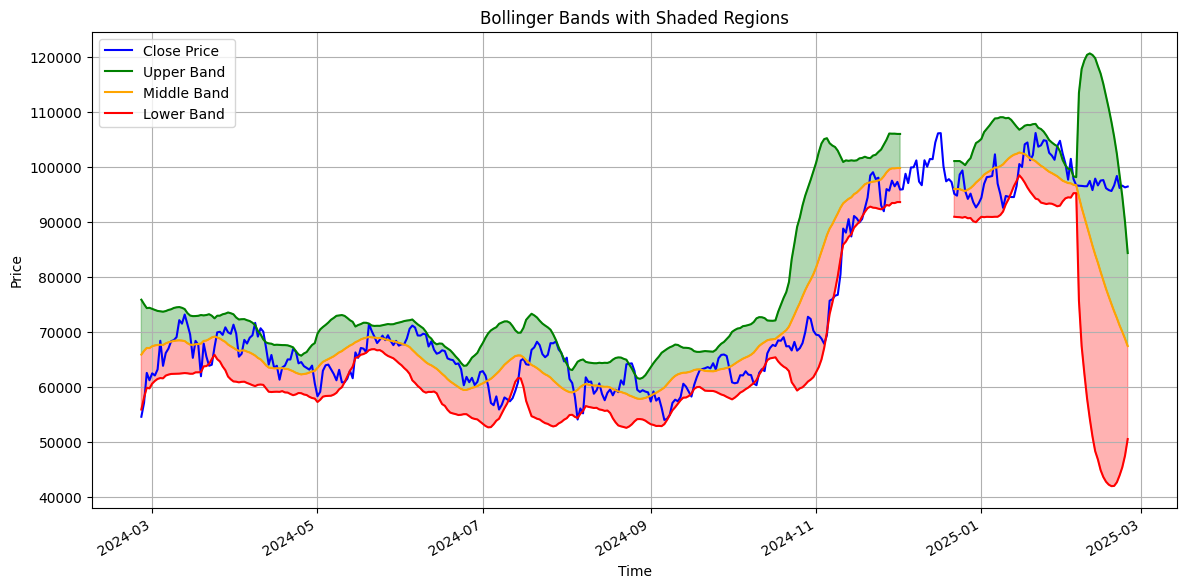

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by time
df = df.sort_values('time').reset_index(drop=True)

# Optionally drop rows with NaNs in Bollinger Bands, if any (depends on your data)
# df = df.dropna(subset=['BB_Upper', 'BB_Middle', 'BB_Lower'])

fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

## 1. Use bollinger bands to predict buy and sell

* Train LSTM on close price, then predict bollinger bands

Epoch 0, Train Loss: 1.1200802326202393, Val Loss: 0.26369696855545044
Epoch 10, Train Loss: 1.1133625507354736, Val Loss: 0.31432804465293884
Epoch 20, Train Loss: 1.1106178760528564, Val Loss: 0.31051093339920044
Epoch 30, Train Loss: 1.1070700883865356, Val Loss: 0.2962033450603485
Epoch 40, Train Loss: 1.1020071506500244, Val Loss: 0.30559206008911133
Epoch 50, Train Loss: 1.0944719314575195, Val Loss: 0.3005567193031311
Epoch 60, Train Loss: 1.0840703248977661, Val Loss: 0.31625908613204956
Epoch 70, Train Loss: 1.0772912502288818, Val Loss: 0.3330233097076416
Epoch 80, Train Loss: 1.0661566257476807, Val Loss: 0.317626953125
Epoch 90, Train Loss: 1.0397237539291382, Val Loss: 0.3067264258861542
Epoch 100, Train Loss: 1.0228731632232666, Val Loss: 0.3037649989128113
Epoch 110, Train Loss: 1.0041961669921875, Val Loss: 0.28648242354393005
Epoch 120, Train Loss: 0.973924458026886, Val Loss: 0.242852121591568
Epoch 130, Train Loss: 0.942971408367157, Val Loss: 0.2767505645751953
Epoc

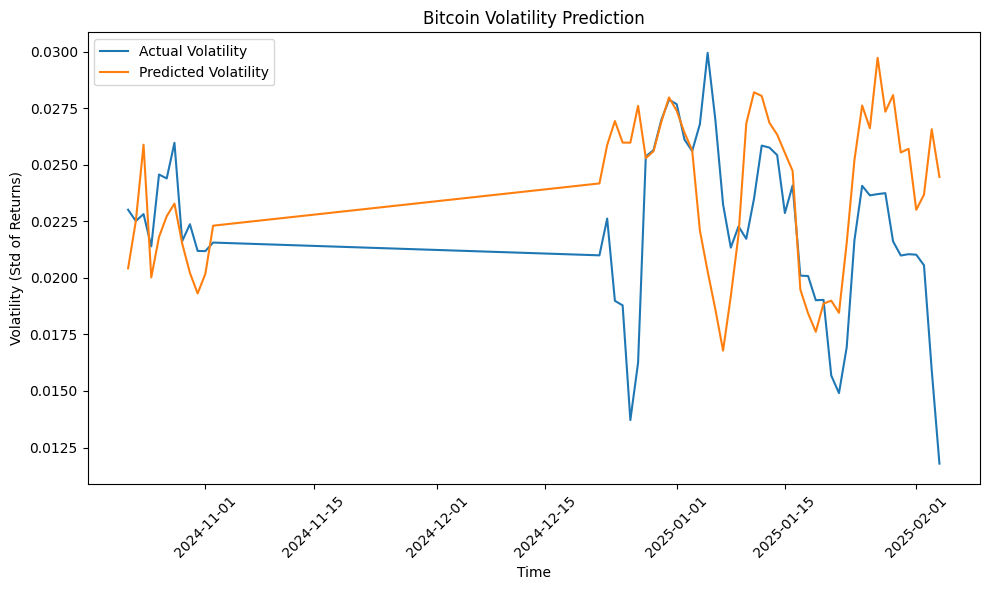

Data range: 2024-02-27 00:00:00 to 2025-02-14 00:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'time' and 'close' columns
# Replace with your actual data loading if needed
# Example: df = pd.read_csv('bitcoin_data.csv')

# Sort by time
df = df.sort_values('time')

# Calculate daily log returns
df['returns'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()  # Remove NaN from shift

# Calculate volatility (e.g., rolling 10-day standard deviation of returns)
vol_window = 10  # Window for volatility calculation
df['volatility'] = df['returns'].rolling(window=vol_window).std().shift(-vol_window)
df = df.dropna()  # Drop NaN from rolling and shift

# Prepare data with a lookback window
lookback = 10  # Use 10 past days of returns to predict future volatility
scaler = StandardScaler()
returns_values = df['returns'].values.reshape(-1, 1)
scaled_returns = scaler.fit_transform(returns_values)

# Target: scaled volatility
vol_scaler = StandardScaler()
volatility_values = df['volatility'].values.reshape(-1, 1)
scaled_volatility = vol_scaler.fit_transform(volatility_values)

# Create sequences
X_data, y_data = [], []
for i in range(lookback, len(scaled_returns) - vol_window):
    X_data.append(scaled_returns[i-lookback:i])  # Past 'lookback' returns
    y_data.append(scaled_volatility[i])          # Volatility at current point

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = X_data.reshape((X_data.shape[0], lookback, 1))  # [samples, timesteps, features]

# Split into train and test (no shuffling for time series)
train_size = int(0.8 * len(X_data))
X_train_data = X_data[:train_size]
X_test_data = X_data[train_size:]
y_train_data = y_data[:train_size]
y_test_data = y_data[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).view(-1, 1)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Output from last time step
        out = self.linear(out)
        return out

# Initialize model, loss, and optimizer
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Lower LR for volatility

# Training loop
model.train()
for epoch in range(150):  # More epochs for finer tuning
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_test_tensor)
            val_loss = criterion(val_output, y_test_tensor)
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')
        model.train()

# Evaluate and predict
model.eval()
with torch.no_grad():
    val_output = model(X_test_tensor)
    val_loss = criterion(val_output, y_test_tensor)
    print(f'Final Validation Loss: {val_loss.item()}')

# Inverse transform predictions for plotting
predictions = vol_scaler.inverse_transform(val_output.numpy())
actual = vol_scaler.inverse_transform(y_test_tensor.numpy())

# Align time for test set (accounting for lookback and vol_window offset)
test_times = df['time'].iloc[train_size + lookback:train_size + lookback + len(predictions)]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_times, actual, label='Actual Volatility')
plt.plot(test_times, predictions, label='Predicted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility (Std of Returns)')
plt.title('Bitcoin Volatility Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Print min/max time for reference
print(f"Data range: {df['time'].min()} to {df['time'].max()}")

Scaled close shape: (354, 1), min: -2.9279620866308957, max: 2.704950671035082
X_data shape: (343, 10, 1), y_data shape: (343, 1)
X_train shape: torch.Size([274, 10, 1]), y_train shape: torch.Size([274, 1])
X_test shape: torch.Size([69, 10, 1]), y_test shape: torch.Size([69, 1])
Epoch 0, Train Loss: 1.0239933729171753, Val Loss: 0.9540020227432251
Epoch 10, Train Loss: 1.0162841081619263, Val Loss: 0.9553179740905762
Epoch 20, Train Loss: 1.013750433921814, Val Loss: 0.9513158202171326
Epoch 30, Train Loss: 1.0056949853897095, Val Loss: 0.9424064755439758
Epoch 40, Train Loss: 0.9946233630180359, Val Loss: 0.9187156558036804
Epoch 50, Train Loss: 0.9785104990005493, Val Loss: 0.9647809267044067
Epoch 60, Train Loss: 0.9688658118247986, Val Loss: 0.986369788646698
Epoch 70, Train Loss: 0.9615499973297119, Val Loss: 0.9805252552032471
Epoch 80, Train Loss: 0.9467213153839111, Val Loss: 0.97999507188797
Epoch 90, Train Loss: 0.9354654550552368, Val Loss: 0.9932098388671875
Final Validatio

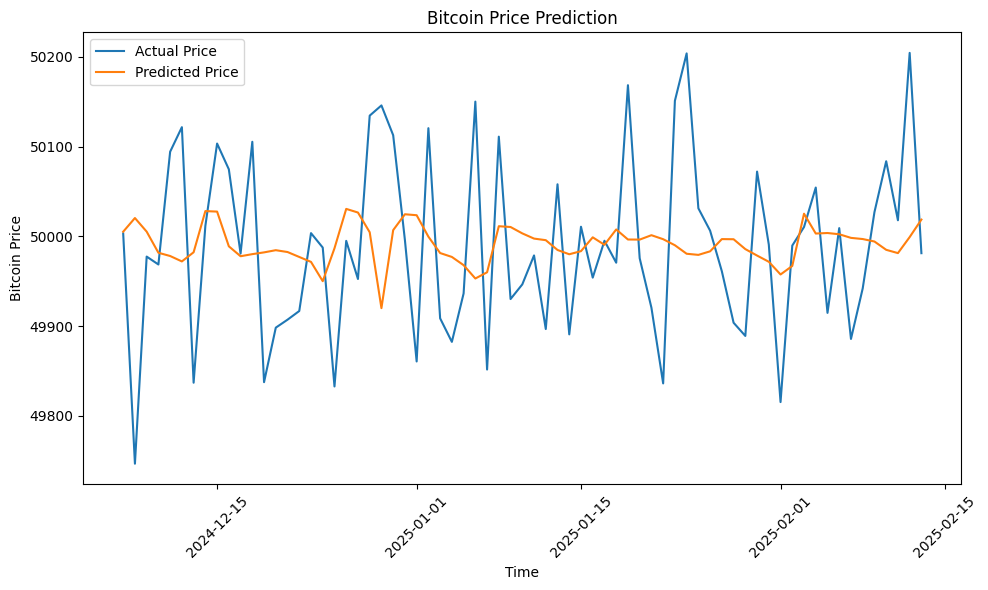

Data range: 2024-02-27 00:00:00 to 2025-02-14 00:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Dummy data for demonstration (replace with your actual data)
dates = pd.date_range(start="2024-02-27", end="2025-02-14", freq='D')
df = pd.DataFrame({'time': dates, 'close': np.random.randn(len(dates)) * 100 + 50000})
df = df.sort_values('time')

# Prepare data with a lookback window
lookback = 10  # Use 10 past days to predict next day
scaler = StandardScaler()
close_values = df['close'].values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_values)

# Debug: Check scaled data
print(f"Scaled close shape: {scaled_close.shape}, min: {scaled_close.min()}, max: {scaled_close.max()}")

# Create sequences
X_data, y_data = [], []
for i in range(lookback, len(scaled_close) - 1):
    X_data.append(scaled_close[i-lookback:i])  # Past 'lookback' days
    y_data.append(scaled_close[i])            # Next day's price

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = X_data.reshape((X_data.shape[0], lookback, 1))  # [samples, timesteps, features]

# Debug: Check sequence shapes
print(f"X_data shape: {X_data.shape}, y_data shape: {y_data.shape}")

# Split into train and test (no shuffling for time series)
train_size = int(0.8 * len(X_data))
X_train_data = X_data[:train_size]
X_test_data = X_data[train_size:]
y_train_data = y_data[:train_size]
y_test_data = y_data[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_data, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_data, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_data, dtype=torch.float32).view(-1, 1)

# Debug: Check tensor shapes
print(f"X_train shape: {X_train_tensor.shape}, y_train shape: {y_train_tensor.shape}")
print(f"X_test shape: {X_test_tensor.shape}, y_test shape: {y_test_tensor.shape}")

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]  # Output from last time step
        out = self.linear(out)
        return out

# Initialize model, loss, and optimizer
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Prevent exploding gradients
    optimizer.step()
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_output = model(X_test_tensor)
            val_loss = criterion(val_output, y_test_tensor)
        print(f"Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")
        model.train()

# Evaluate and predict
model.eval()
with torch.no_grad():
    val_output = model(X_test_tensor)
    val_loss = criterion(val_output, y_test_tensor)
    print(f"Final Validation Loss: {val_loss.item()}")

# Inverse transform predictions for plotting
predictions = scaler.inverse_transform(val_output.numpy())
actual = scaler.inverse_transform(y_test_tensor.numpy())

# Debug: Check prediction length
print(f"Predictions length: {len(predictions)}, Actual length: {len(actual)}")

# Align time for test set (accounting for lookback offset)
test_start_idx = train_size + lookback
test_end_idx = test_start_idx + len(predictions)
if test_end_idx > len(df):
    test_end_idx = len(df)
test_times = df['time'].iloc[test_start_idx:test_end_idx]

# Debug: Check time alignment
print(f"Test times length: {len(test_times)}, df length: {len(df)}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_times, actual, label='Actual Price')
plt.plot(test_times, predictions, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print data range
print(f"Data range: {df['time'].min()} to {df['time'].max()}")

In [ ]:
X_test.sort_values(by='time')


In [ ]:
X_test

In [ ]:
# @title time vs predictions

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['predictions']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('predictions')

In [ ]:
# @title time vs predictions

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['close']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_test.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('close')